# Keras를 사용한 반복적 인 신경망 (RNN)

## 시작하기

RNN (Recurrent Neural Network)은 시계열 또는 자연어와 같은 시퀀스 데이터를 모델링하는 데 강력한 신경망 클래스입니다.

도식적으로, RNN 계층은 `for` 루프를 사용하여 시퀀스의 시간 단계를 반복하고, 지금까지 본 시간 단계에 대한 정보를 인코딩하는 내부 상태를 유지합니다.

Keras RNN API는 다음에 중점을두고 설계되었습니다.

- **사용 편리성**: 내장 `keras.layers.RNN`, `keras.layers.LSTM`, `keras.layers.GRU` 레이어를 사용하여 어려운 구성 선택 없이도 반복 모델을 빠르게 구축할 수 있습니다.

- **사용자 정의 용이성** : 사용자 정의 동작으로 자체 RNN 셀 계층 ( `for` 루프의 내부 부분)을 정의하고 일반 `keras.layers.RNN` 계층 ( `for` 루프 자체)과 함께 사용할 수 있습니다. 이를 통해 최소한의 코드로 다양한 연구 아이디어를 유연한 방식으로 신속하게 프로토 타이핑 할 수 있습니다.

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 내장 RNN 레이어: 간단한 예

Keras에는 세 개의 내장 RNN 레이어가 있습니다.

1. `keras.layers.SimpleRNN`: 이전 타임스텝의 출력이 다음 타임스텝으로 공급되는 완전히 연결된 RNN입니다.

2. `keras.layers.GRU`: [Cho 등(2014년)](https://arxiv.org/abs/1406.1078)에 의해 처음 제안되었습니다.

3. `keras.layers.LSTM`: [Hochreiter 및 Schmidhuber(1997년)](https://www.bioinf.jku.at/publications/older/2604.pdf)에 의해 처음 제안되었습니다.

2015년 초, LSTM 및 GRU의 재사용 가능한 오픈 소스 Python 구현이 Keras에 처음 이루어졌습니다.

다음은 정수 시퀀스를 처리하고 각 정수를 64차원 벡터에 포함시킨 다음 `LSTM` 레이어를 사용하여 벡터 시퀀스를 처리하는 `Sequential` 모델의 간단한 예입니다.

In [2]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128))   # (None, 64)(64,128) + (None,128)(128,128) + (128,)

# Add a Dense layer with 10 units.
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


내장 RNN은 여러 유용한 기능을 지원합니다.

- `dropout` 및 `recurrent_dropout` 인수를 통한 반복 드롭아웃
- `go_backwards` 인수를 통해 입력 시퀀스를 반대로 처리할 수 있음
- `unroll` 인수를 통한 루프 언롤링(CPU에서 짧은 시퀀스를 처리할 때 속도가 크게 향상될 수 있음)
- 기타 등등

자세한 내용은 [RNN API 설명서](https://keras.io/api/layers/recurrent_layers/)를 참조하세요.

## 출력과 상태

기본적으로, RNN 레이어의 출력에는 샘플당 하나의 벡터가 포함됩니다. 이 벡터는 마지막 타임스텝에 해당하는 RNN 셀 출력으로, 전체 입력 시퀀스에 대한 정보를 포함합니다. 이 출력의 형상은 `(batch_size, units)`이고, 여기서 `units`는 레이어의 생성자에 전달된 `units` 인수에 해당합니다.

`return_sequences=True`를 설정하면 RNN 레이어가 각 샘플(샘플 및 타임스텝당 하나의 벡터)에 대한 전체 출력 시퀀스도 반환할 수 있습니다. 이 출력의 형상은 `(batch_size, timesteps, units)`입니다.

In [3]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


또한 RNN 레이어는 최종 내부 상태를 반환할 수 있습니다. 반환된 상태는 나중에 RNN 실행을 재개하거나 [다른 RNN을 초기화](https://arxiv.org/abs/1409.3215)하는 데 사용될 수 있습니다. 이 설정은 인코더의 최종 상태가 디코더의 초기 상태로 사용되는 인코더-디코더 시퀀스-시퀀스 모델에서 일반적으로 사용됩니다.

내부 상태를 반환하도록 RNN 레이어를 구성하려면 레이어를 생성할 때 `return_state` 매개 변수를 `True` 설정합니다. 참고로 `LSTM`에는 두 개의 상태 텐서가 있지만 `GRU`에는 하나만 있습니다.

레이어의 초기 상태를 구성하려면 추가 키워드 인수 `initial_state`로 레이어를 호출하면 됩니다. 상태의 형상은 아래 예와 같이 레이어의 단위 크기와 일치해야 합니다.

In [4]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

## RNN 레이어 및 RNN 셀

내장된 RNN 레이어 외에도 RNN API는 셀 수준의 API도 제공합니다. 입력 시퀀스의 전체 배치를 처리하는 RNN 레이어와 달리 RNN 셀은 단일 타임스텝만 처리합니다.

셀은 RNN 레이어의 `for` 루프 내부입니다. `keras.layers.RNN` 레이어 내에 셀을 래핑하면 `RNN(LSTMCell(10))`과 같은 시퀀스 배치를 처리할 수 있는 레이어가 얻어집니다.

수학적으로, `RNN(LSTMCell(10))`은 `LSTM(10)`과 동일한 결과를 생성합니다. 실제로, TF v1.x에서 이 레이어를 구현하는 것은 해당 RNN 셀을 생성하고 이를 RNN 레이어에 랩핑하는 것과 같았습니다. 그러나 내장 `GRU` 및 `LSTM` 레이어를 사용하면 CuDNN을 사용할 수 있으므로 성능이 향상될 수 있습니다.

3개의 내장 RNN 셀이 있으며 각 셀은 대응하는 RNN 레이어에 해당합니다.

- `keras.layers.SimpleRNNCell`은 `SimpleRNN` 레이어에 해당합니다.

- `keras.layers.GRUCell`은 `GRU` 레이어에 해당합니다.

- `keras.layers.LSTMCell`은 `LSTM` 레이어에 해당합니다.

일반 `keras.layers.RNN` 클래스와 함께 셀 추상화를 통해 연구를 위한 사용자 정의 RNN 아키텍처를 매우 쉽게 구현할 수 있습니다.

## 크로스 배치 상태 저장

무한할 수도 있는 매우 긴 시퀀스를 처리할 때 **크로스 배치 상태 저장** 패턴을 사용할 수 있습니다.

보통의 경우, RNN 레이어의 내부 상태는 새로운 배치가 인식될 때마다 재설정됩니다(즉, 레이어에 드러나는 모든 샘플은 이전과 독립적인 것으로 가정됨). 레이어는 주어진 샘플을 처리하는 동안에만 상태를 유지합니다.

그래도 시퀀스가 매우 긴 경우, 시퀀스를 더 짧은 시퀀스로 나눈 다음 레이어의 상태를 재설정하지 않고 이 짧은 시퀀스를 RNN 레이어에 순차적으로 공급하는 것이 좋습니다. 이렇게 하면 레이어가 한 번에 하나의 하위 시퀀스만 받더라도 시퀀스 전체에 대한 정보를 유지할 수 있습니다.

생성자에서 `stateful=True`를 설정하여 이 작업을 수행할 수 있습니다.

시퀀스 `s = [t0, t1, ... t1546, t1547]`의 경우 다음과 같이 분할합니다.

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

그리고 다음을 통해 처리합니다.

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

상태를 지우려면 `layer.reset_states()`를 사용할 수 있습니다.

> 참고: 이 설정에서 주어진 배치의 샘플 `i`는 이전 배치의 샘플 `i`가 연속된 것으로 간주됩니다. 즉, 모든 배치에는 동일한 수의 샘플(배치 크기)이 포함되어야 합니다. 예를 들어 배치에 `[sequence_A_from_t0_to_t100, sequence_B_from_t0_to_t100]`이 포함된 경우 다음 배치에는 `[sequence_A_from_t101_to_t200, sequence_B_from_t101_to_t200]`이 포함되어야 합니다.

다음은 완전한 예입니다.

In [5]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
lstm_layer.reset_states()


### RNN 상태 재사용

<a id="rnn_state_reuse"></a>

RNN 레이어의 기록된 상태는 `layer.weights()`에 포함되지 않습니다. RNN 레이어의 상태를 재사용하려면 `layer.states`로 상태 값을 가져오고 `new_layer(inputs, initial_state=layer.states)` 또는 모델 하위 클래싱과 같은 Keras functional API를 통해 이를 새 레이어의 초기 상태로 사용할 수 있습니다.

순차 모델은 하나의 입력 및 출력이 있는 레이어만 지원하여 초기 상태가 추가로 입력되면 사용이 불가능하므로 이 경우에 사용할 수 없습니다.

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


## 양방향 RNN

시계열 이외의 시퀀스(예: 텍스트)의 경우, RNN 모델이 시퀀스를 처음부터 끝까지 처리할 뿐만 아니라 역방향으로도 처리하면 성능이 더 좋아지는 경우가 종종 있습니다. 예를 들어, 문장에서 다음 단어를 예측하려면 단어 앞에 오는 단어뿐만 아니라 단어 주변의 컨텍스트까지 있으면 유용한 경우가 많습니다.

Keras는 `keras.layers.Bidirectional` 래퍼와 같은 이러한 양방향 RNN을 쉽게 구축할 수 있는 API를 제공합니다.

In [7]:
model = keras.Sequential()

model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


막후에서 `Bidirectional`은 전달된 RNN 레이어를 복사하고 새로 복사된 레이어의 `go_backwards` 필드를 뒤집어 입력을 역순으로 처리합니다.

`Bidirectional` RNN의 출력은 기본적으로, 정뱡향 레이어 출력과 역방향 레이어 출력이 합산된 것입니다. 연결과 같은 다른 병합 동작이 필요한 경우 `Bidirectional` 래퍼 생성자에서 `merge_mode` 매개변수를 변경합니다. `Bidirectional`에 대한 자세한 내용은 [API 설명서](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/)를 확인하세요.

## 성능 최적화 및 CuDNN 커널

TensorFlow 2.0에서 내장 LSTM 및 GRU 레이어는 GPU를 사용할 수 있을 때 기본적으로 CuDNN 커널을 활용하도록 업데이트되었습니다. 이 변경으로 인해 이전 `keras.layers.CuDNNLSTM/CuDNNGRU` 레이어는 더 이상 사용되지 않으며 실행 기반이 되는 하드웨어를 신경 쓰지 않고 모델을 빌드할 수 있습니다.

CuDNN 커널은 특정한 가정 하에 구축되므로 다음과 같이 **내장 LSTM 또는 GRU 레이어의 기본값을 변경하면 레이어가 CuDNN 커널을 사용할 수 없게 됩니다**.

- `activation` 함수를 `tanh`에서 다른 값으로 변경
- `recurrent_activation` 함수를 `sigmoid`에서 다른 값으로 변경
- 0보다 큰 `recurrent_dropout` 사용
- `unroll`을 True로 설정(이 경우, LSTM/GRU가 내부 `tf.while_loop`를 언롤된 `for` 루프로 분해함)
- `use_bias`를 False로 설정
- 입력 데이터가 정확히 오른쪽 패딩 처리되지 경우에 마스킹 사용(마스크가 정확히 오른쪽 패딩 처리된 데이터에 해당하는 경우에는 CuDNN을 사용할 수 있으며, 이것이 가장 일반적인 경우임)

제약 조건의 자세한 목록은 [LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/) 및 [GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/) 레이어에 대한 설명서를 참조하십시오.

### 가능한 경우 CuDNN 커널 사용

성능 차이를 보여주기 위해 간단한 LSTM 모델을 만들어 보겠습니다.

입력 시퀀스로 MNIST 숫자의 행 시퀀스(각 픽셀 행을 하나의 타임스텝으로 취급)를 사용하고 숫자의 레이블을 예측해 보겠습니다.

In [13]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# print(allow_cudnn_kernel)
# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        print("allow_cudnn_kernel")
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


MNIST 데이터세트를 로드합니다.

In [14]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

모델 인스턴스를 만들고 훈련시키겠습니다.

모델의 손실 함수로 `sparse_categorical_crossentropy`를 선택합니다. 모델의 출력은 `[batch_size, 10]` 형상을 갖습니다. 모델의 목표는 정수 벡터이며 각 정수는 0에서 9 사이의 범위에 있습니다.

In [15]:
model = build_model(allow_cudnn_kernel=True)

model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

allow_cudnn_kernel
938/938 [==============================] - 11s 11ms/step - loss: 1.3818 - accuracy: 0.5488 - val_loss: 0.6329 - val_accuracy: 0.7851


이제 CuDNN 커널을 사용하지 않는 모델과 비교해 보겠습니다.

In [16]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

938/938 [==============================] - 113s 120ms/step - loss: 0.4687 - accuracy: 0.8562 - val_loss: 0.2910 - val_accuracy: 0.9075


NVIDIA GPU 및 CuDNN이 설치된 시스템에서 실행하는 경우, CuDNN으로 빌드된 모델은 일반 TensorFlow 커널을 사용하는 모델에 비해 훈련 속도가 훨씬 빠릅니다.

동일한 CuDNN 지원 모델을 사용하여 CPU 전용 환경에서 추론을 실행할 수도 있습니다. 아래의 `tf.device` 주석은 장치 배치를 강제합니다. 사용 가능한 GPU가 없는 경우 모델은 기본적으로 CPU에서 실행됩니다.

더 이상 실행 기반이 되는 하드웨어에 대해 걱정할 필요가 없습니다. 정말 멋지지 않나요?

allow_cudnn_kernel
Predicted result is: [3], target result is: 5


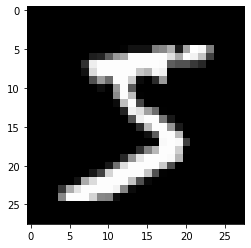

In [17]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## 목록/사전 입력 또는 중첩 입력이 있는 RNN

중첩 구조를 통해 실행자는 단일 타임스텝 내에 더 많은 정보를 포함할 수 있습니다. 예를 들어, 비디오 프레임에는 오디오 및 비디오 입력이 동시에 있을 수 있습니다. 이 경우의 데이터 형상은 다음과 같습니다.

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

또 다른 예로, 필기 데이터는 펜의 압력 정보뿐만 아니라 현재 위치에 대한 좌표 x 및 y를 모두 가질 수 있습니다. 따라서 데이터 표현은 다음과 같습니다.

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

다음 코드는 이러한 구조화된 입력을 허용하는 사용자 정의 RNN 셀을 빌드하는 방법의 예를 보여줍니다.

### 중첩된 입력/출력을 지원하는 사용자 정의 셀 정의하기

고유한 레이어를 작성하기 위한 자세한 내용은 [하위 클래화를 통해 새로운 레이어 및 모델 만들기](https://www.tensorflow.org/guide/keras/custom_layers_and_models/)를 참조하세요.

In [24]:
x = tf.constant(np.arange(4).reshape(1,2,2))
w = tf.constant(np.arange(16).reshape(2,2,2,2))

output = tf.einsum("bij,ijkl->bkl", x, w)
output

<tf.Tensor: shape=(1, 2, 2), dtype=int32, numpy=
array([[[56, 62],
        [68, 74]]])>

In [18]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}


### 중첩된 입력/출력으로 RNN 모델 구축

`keras.layers.RNN` 레이어와 방금 정의한 사용자 정의 셀을 이용하는 Keras 모델을 빌드해 보겠습니다.

In [25]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

### 무작위로 생성된 데이터로 모델 훈련

이 모델에는 적합한 후보 데이터세트가 없기 때문에 임의의 Numpy 데이터를 데모용으로 사용합니다.

In [26]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

10/10 [==============================] - 1s 60ms/step - loss: 0.9115 - rnn_4_loss: 0.3218 - rnn_4_1_loss: 0.5897 - rnn_4_accuracy: 0.1095 - rnn_4_1_accuracy: 0.0346


Keras `keras.layers.RNN` 레이어를 사용하면 시퀀스 내 개별 스텝에 대한 수학적 논리만 정의하면 되며 시퀀스 반복은 `keras.layers.RNN` 레이어가 처리해 줍니다. 새로운 형태의 RNN(예: LSTM 변형) 프로토타입을 빠르게 시도해볼 수 있는 매우 강력한 방법입니다.

자세한 내용은 [API 설명서](https://https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN/)를 참조하세요.